### Author: Kyle Tranfaglia ###
### Course: DSCI 470 ###
### Assignment: The Project ###
### Last Updated: 10/23/24 ###

## Background: ##

## Questions: ## 
### How do opening choices and event types differ across Elo ratings, and are certain openings more likely in specific events or Elo ranges? ###
### How do rating differences and player Elo impact game outcomes and the predictability of the game results? ### 
### Which game features (event type, opening, result) have the most predictive power for Elo, and how can these insights inform match-making criteria? ###

## Prepare for Analysis: Import Libraries and Read in Data

In [2]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay

# Read in data set and strip beginning spaces from the 'Event' column
df_chess = pd.read_csv("Data/Big_chess_data.csv", nrows=1000000, converters= {'Event': lambda x: x.strip() if isinstance(x, str) else x})


## Utility Functions ##

In [3]:
# Set up the plotting style
sns.set_theme(style='whitegrid')


# Function to plot bar charts
def plot_frequencies(counts, title, xlabel, ylabel):
    # Handle frequencies with too many categories to appropriately disaplay (n > 50)
    top_n = 50
    counts = counts.nlargest(top_n)

    plt.figure(figsize=(12, 8))
    sns.barplot(x=counts.index, y=counts.values, hue=counts.index, legend=False, palette='viridis')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.yscale('log')
    plt.xticks(rotation=90)  # Rotate x labels for better readability
    plt.show()


# Extract the first word of a column entry
def extract_first_word(entry):
    return entry.split()[0]


# Extract the first two words of a column entry
def extract_first_two_words(entry):
    words = entry.replace(":", "").replace(",", "").split()  # Remove colons and commas, then split the string
    return ' '.join(words[:2]) if len(words) > 1 else words[0]


# Assign a player strength classification to an Elo
def classify_elo(elo):
    if elo <= 1200:
        return 'Beginner'
    elif elo <= 1800:
        return 'Intermediate'
    elif elo <= 2000:
        return 'Advanced'
    elif elo <= 2200:
        return 'Expert'
    else:
        return 'Master'

## Explore the Data ##

             WhiteElo        BlackElo  WhiteRatingDiff  BlackRatingDiff
count  1000000.000000  1000000.000000    999186.000000    999186.000000
mean      1744.800411     1743.103784         0.678818        -0.268921
std        264.101504      265.623353        22.867394        21.872902
min        782.000000      728.000000      -555.000000      -570.000000
25%       1563.000000     1560.000000        -9.000000       -10.000000
50%       1744.000000     1742.000000         1.000000        -1.000000
75%       1922.000000     1922.000000        10.000000         9.000000
max       3006.000000     3069.000000       669.000000       644.000000

               Event            White       Black Result     UTCDate   UTCTime  \
0         Classical          eisaaaa    HAMID449    1-0  2016.06.30  22:00:01   
1             Blitz           go4jas  Sergei1973    0-1  2016.06.30  22:00:01   
2  Blitz tournament  Evangelistaizac      kafune    1-0  2016.06.30  22:00:02   
3    Correspondence       

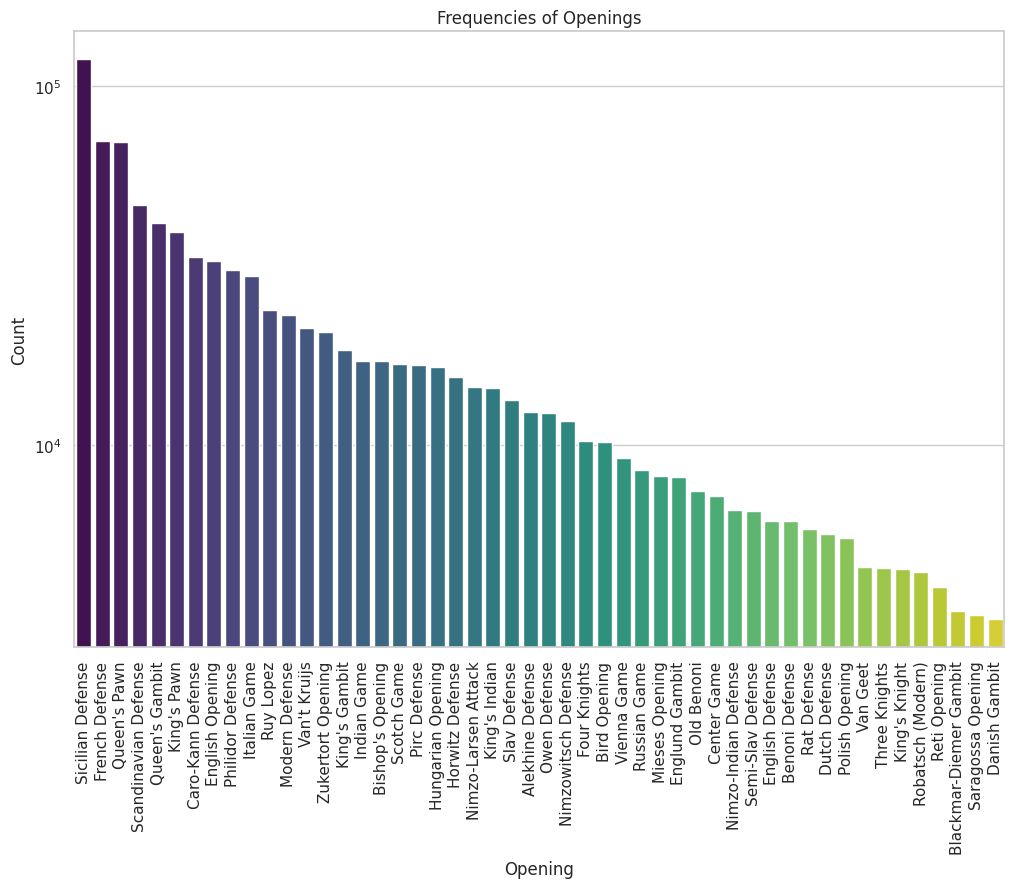


Frequency of ECO
A00    66841
C00    46913
B01    46668
A40    45831
D00    36295
       ...  
D62        1
E55        1
B64        1
E02        1
D29        1
Name: count, Length: 488, dtype: int64


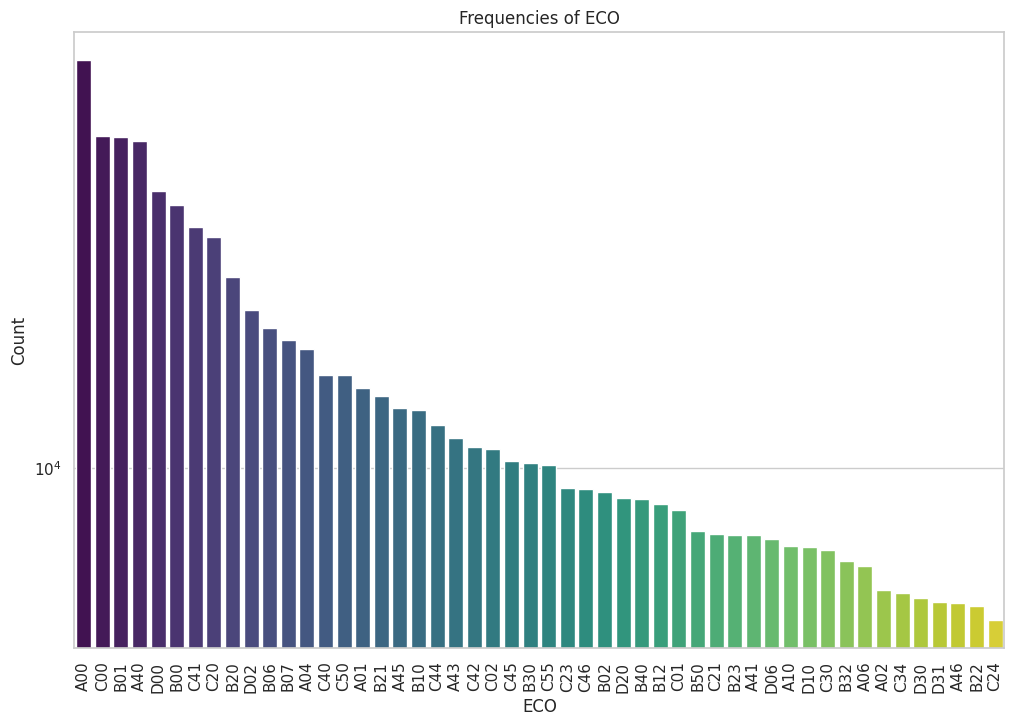


Frequency of TimeControl
300+0      170949
180+0      151861
60+0       148666
600+0       93821
30+0        39947
            ...  
360+30          1
5400+1          1
3600+16         1
720+30          1
1080+25         1
Name: count, Length: 583, dtype: int64


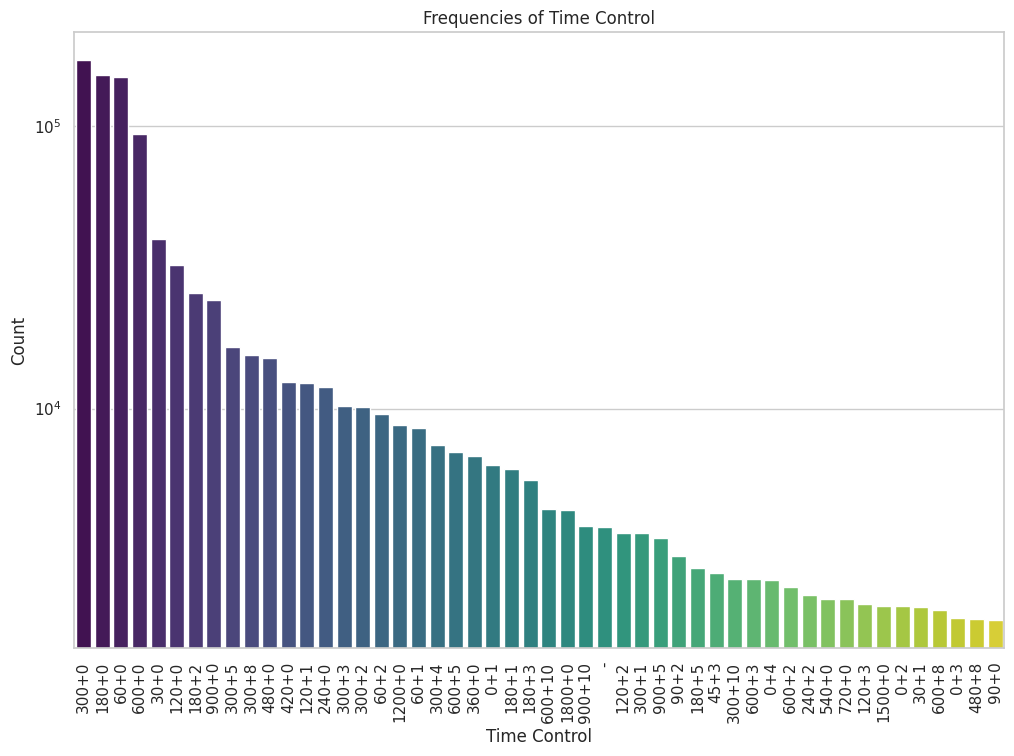


Frequency of Event
Blitz                   374775
Classical               241423
Bullet                  196239
Bullet tournament        80541
Blitz tournament         75786
Classical tournament     27418
Correspondence            3818
Name: count, dtype: int64


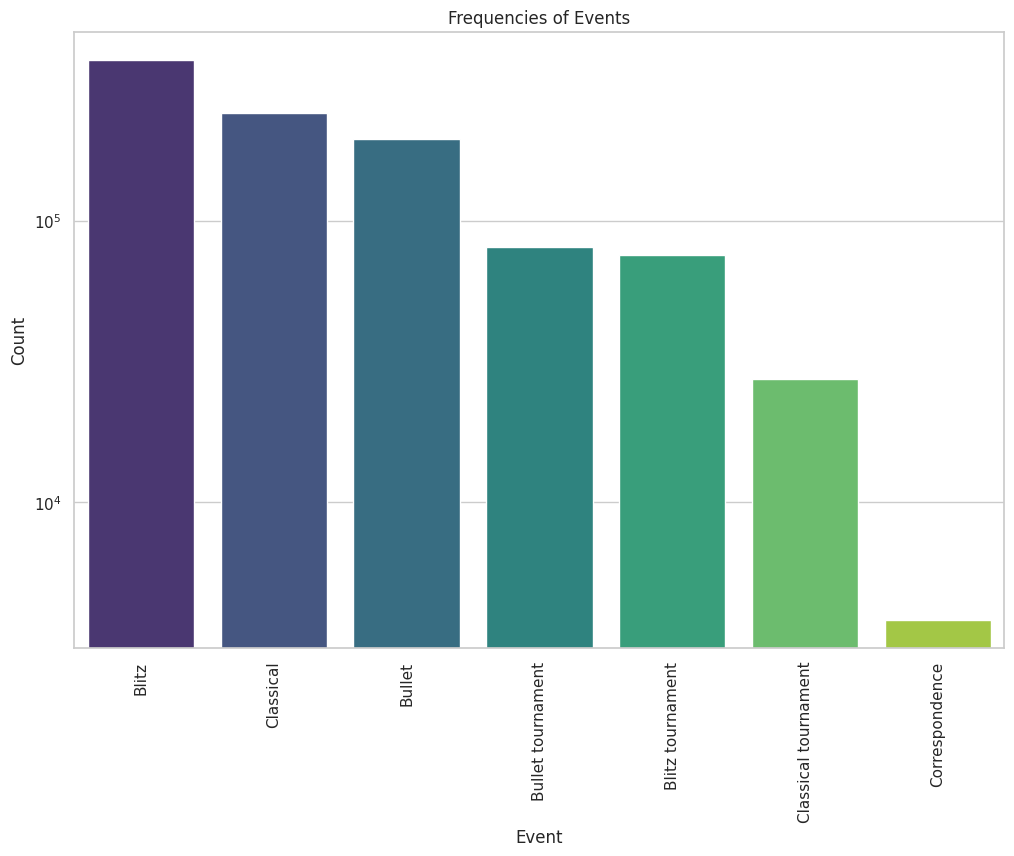


Frequency of Termination
Normal              678954
Time forfeit        318657
Abandoned             2367
Rules infraction        22
Name: count, dtype: int64


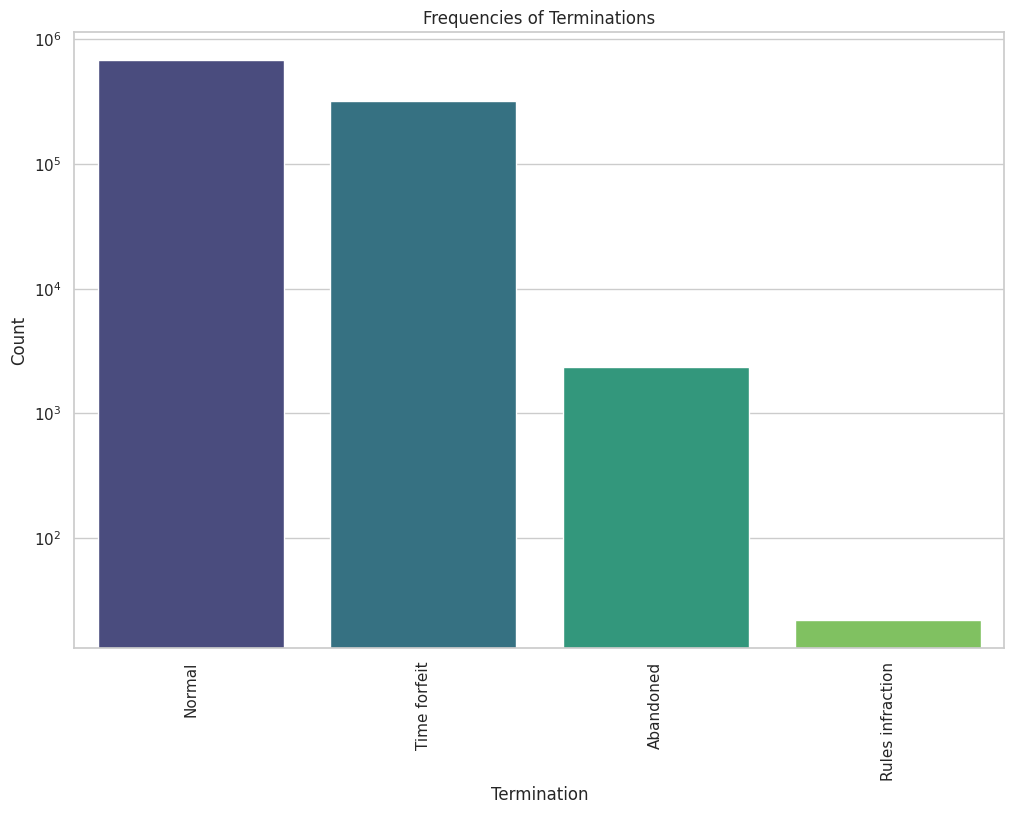


Frequency of EloGroup
Intermediate    584406
Advanced        258524
Expert          112826
Master           33590
Beginner         10654
Name: count, dtype: int64


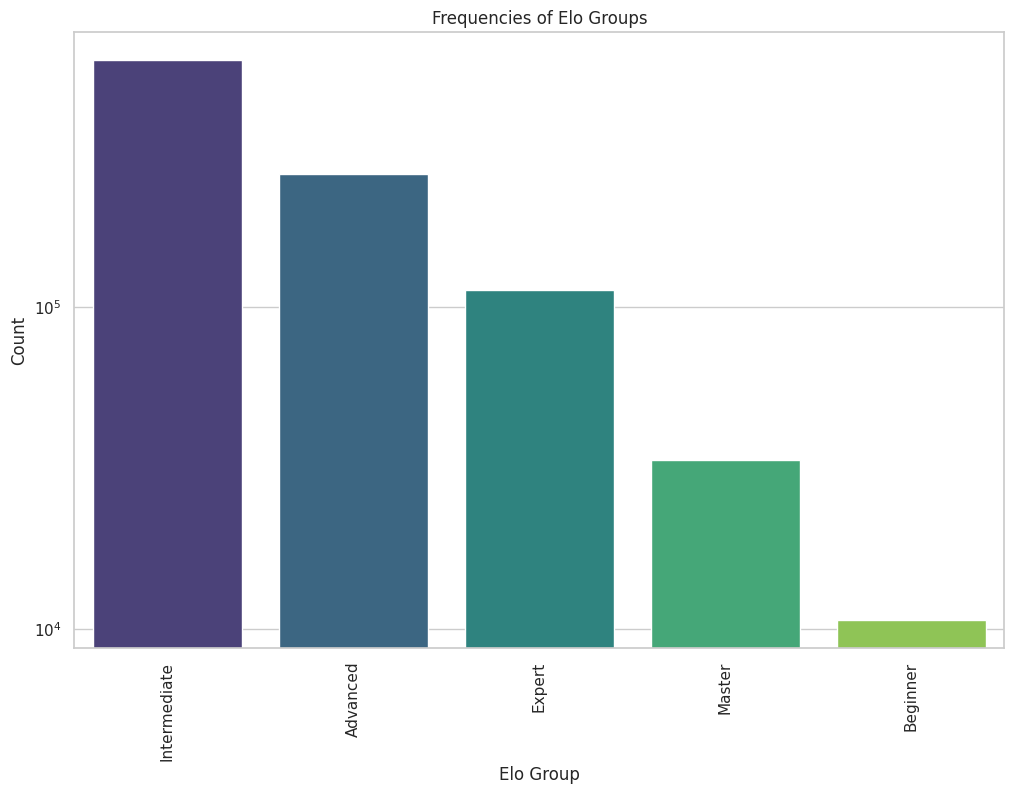

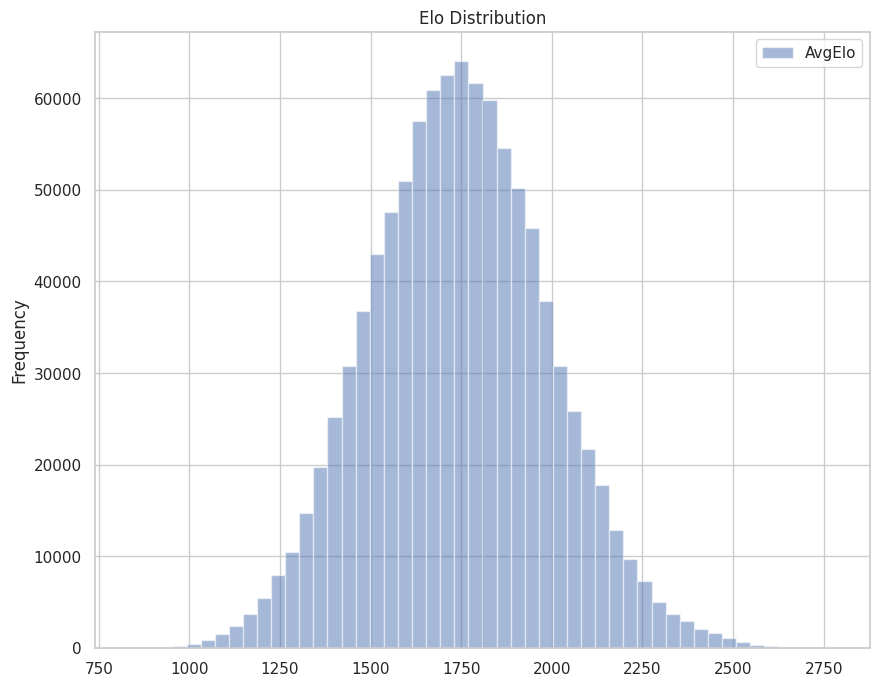

<Figure size 1000x800 with 0 Axes>

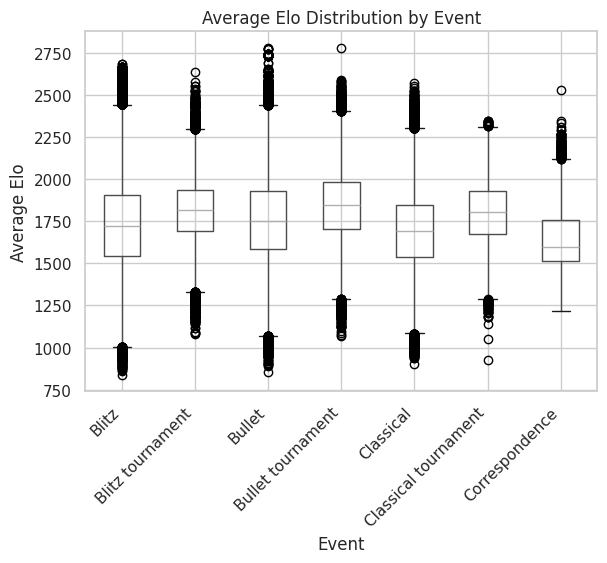

In [4]:
'''Display basic information on the data'''
# Display some data, statistics, and summary info
print(df_chess.describe())
print("\n", df_chess.head())

'''Add five new columns to the dataset for analysis'''
# Create a new column for the Elo group of each player
df_chess['WhiteEloGroup'] = df_chess['WhiteElo'].apply(classify_elo)
df_chess['BlackEloGroup'] = df_chess['BlackElo'].apply(classify_elo)

# Calculate average Elo and Elo group based on the average Elo for each game and add to the DataFrame
df_chess['AvgElo'] = df_chess[['WhiteElo', 'BlackElo']].mean(axis=1)
df_chess['EloGroup'] = df_chess['AvgElo'].apply(classify_elo)

# Create a new column with generalized openings (group all opening variations)
df_chess['generalized_Opening'] = df_chess['Opening'].apply(extract_first_two_words)

'''Get the mode for each feature, display the values in descending order, and represent it with a bar plot figure'''
# Get and display data fequencies for some features
opening_counts = df_chess['generalized_Opening'].value_counts().sort_values(ascending=False)
print("\nFrequency of", opening_counts)
plot_frequencies(opening_counts, 'Frequencies of Openings', 'Opening', 'Count')

ECO_counts = df_chess['ECO'].value_counts().sort_values(ascending=False)
print("\nFrequency of", ECO_counts)
plot_frequencies(ECO_counts, 'Frequencies of ECO', 'ECO', 'Count')

time_control_counts = df_chess['TimeControl'].value_counts().sort_values(ascending=False)
print("\nFrequency of", time_control_counts)
plot_frequencies(time_control_counts, 'Frequencies of Time Control', 'Time Control', 'Count')

event_counts = df_chess['Event'].value_counts().sort_values(ascending=False)
print("\nFrequency of", event_counts)
plot_frequencies(event_counts, 'Frequencies of Events', 'Event', 'Count')

termination_counts = df_chess['Termination'].value_counts().sort_values(ascending=False)
print("\nFrequency of", termination_counts)
plot_frequencies(termination_counts, 'Frequencies of Terminations', 'Termination', 'Count')

elo_group_counts = df_chess['EloGroup'].value_counts().sort_values(ascending=False)
print("\nFrequency of", elo_group_counts)
plot_frequencies(elo_group_counts, 'Frequencies of Elo Groups', 'Elo Group', 'Count')

'''Plot a historgram and boxplots for Elo distributions by event'''
df_chess[['AvgElo']].plot(kind='hist', bins=50, alpha=0.5, title='Elo Distribution', figsize=(10, 8))

# Create the boxplot for Average Elo ratings by Event
plt.figure(figsize=(10, 8))
df_chess.boxplot(column='AvgElo', by='Event')

plt.title('Average Elo Distribution by Event')
plt.xlabel('Event')
plt.ylabel('Average Elo')

plt.xticks(rotation=45, ha='right')
plt.suptitle('')  # Remove the automatic generated title
plt.show()

# # Create the boxplot with subplots for White and Black Elo ratings
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# # Boxplot for WhiteElo
# df_chess.boxplot(column='WhiteElo', by='Event', ax=axes[0])
# axes[0].set_title('White Elo Distribution by Event')
# axes[0].set_xlabel('Event')
# axes[0].set_ylabel('White Elo')

# # Boxplot for BlackElo
# df_chess.boxplot(column='BlackElo', by='Event', ax=axes[1])
# axes[1].set_title('Black Elo Distribution by Event')
# axes[1].set_xlabel('Event')
# axes[1].set_ylabel('Black Elo')

# # Rotate x-axis labels for both subplots
# for ax in axes:
#     plt.sca(ax)
#     plt.xticks(rotation=45, ha='right')

# plt.suptitle('')  # Remove the automatic generated title
# plt.show()

## Explore the Question: How do opening choices and event types differ across Elo ratings, and are certain openings more likely in specific events or Elo ranges? ##

In [5]:
'''Calculate and display the average elo for black, white, and combined with a classification for the elo for each generalized opening'''
# Get the average elo of players that use each opening by grouping 'generalized_Opening' and 'WhiteElo' and 'BlackElo'
avg_opening_elo = df_chess.groupby('generalized_Opening')[['WhiteElo', 'BlackElo']].mean()

# Create a new column for combined average Elo & categorize each opening based on its average Elo
avg_opening_elo['AvgElo'] = avg_opening_elo.mean(axis=1)
avg_opening_elo['EloGroup'] = avg_opening_elo['AvgElo'].apply(classify_elo)
print("Elo by Chess Opening", avg_opening_elo)

# Group the openings by the average Elo Group and display them
print("\nOpening by Average Elo Group")
for group, openings in avg_opening_elo.groupby('EloGroup'):
    print(f"\nElo Group: {group}")
    print(openings[['AvgElo']].sort_values(by='AvgElo', ascending=False))

'''Use the elo group frequencies for each opening and the total number of players in each elo group to normalize the mode of each 
opening within an elo group and display the most frequent elo group for each generalized opening'''

# Combine White and Black Elo groups into a single DataFrame for counting
elo_groups_combined = pd.concat([
    df_chess[['generalized_Opening', 'WhiteEloGroup']].rename(columns={'WhiteEloGroup': 'EloGroup'}),
    df_chess[['generalized_Opening', 'BlackEloGroup']].rename(columns={'BlackEloGroup': 'EloGroup'})])

# Count the frequency of each Elo group for each opening & count the total number of players in each Elo group
elo_group_counts = elo_groups_combined.groupby(['generalized_Opening', 'EloGroup']).size().reset_index(name='Count')
total_players_by_elo_group = elo_group_counts.groupby('EloGroup')['Count'].sum()

# Normalize the frequency of openings within each Elo group by dividing by the total number of players in that group
# This is significant as the elo groups are inbalanced which would lead to bias
elo_group_counts['NormalizedCount'] = elo_group_counts.apply(
    lambda row: row['Count'] / total_players_by_elo_group[row['EloGroup']], axis=1)

# For each opening, find the Elo group with the highest frequency
most_frequent_elo_group = (
    elo_group_counts.groupby('generalized_Opening')
    .apply(lambda x: x.loc[x['NormalizedCount'].idxmax()])  # Get the row with the highest count for each opening
    .reset_index(drop=True))
print("\nOpeining by Most Frequent Elo Group", most_frequent_elo_group)

# Iterate through the groups and display the openings in each Elo Group
print("\nOpening by Most Frequent Elo Group")
for group, openings in most_frequent_elo_group.groupby('EloGroup'):
    print(f"\nElo Group: {group}")
    print(openings[['generalized_Opening', 'NormalizedCount']].sort_values(by='NormalizedCount', ascending=False))

'''Calculate and display the top 5 most frequent openings played for each elo group with a percentage of the total games that the opening was played'''
# Calculate the frequency of each 'generalized_Opening' within each 'EloGroup'
top_openings_by_elo_group = (
    df_chess.groupby('EloGroup')['generalized_Opening']
    .value_counts()
    .groupby(level=0)
    .nlargest(5)
    .reset_index(level=0, drop=True)
).reset_index(name='Frequency')

total_games_by_elo_group = df_chess['EloGroup'].value_counts()  # Calculate the total games for each Elo group

# Calculate the percentage of total games each opening represents within its Elo group
top_openings_by_elo_group['Percentage'] = top_openings_by_elo_group.apply(
    lambda row: f"{(row['Frequency'] / total_games_by_elo_group[row['EloGroup']]) * 100:.2f}%", axis=1)
print("\nTop Openings by Elo Group", top_openings_by_elo_group)

'''Calculate and display the top 5 most frequent openings played for each event with a percentage of the total games that the opening was played'''
# Group 'Event' and frequencies of each 'generalized_Opening' within each event, then get the top 5 most frequent openings
top_openings_by_event = (
    df_chess.groupby('Event')['generalized_Opening']
    .value_counts()
    .groupby(level=0)
    .nlargest(5)
    .reset_index(level=0, drop=True)
).reset_index(name='Frequency')

total_games_by_event = df_chess['Event'].value_counts()  # Get the total amount of games played for each event 

# Calculate the percentage of the total games that an opening was played for each event, and create a formatted column 
top_openings_by_event['Percentage'] = top_openings_by_event.apply(
    lambda row: f"{(row['Frequency'] / total_games_by_event[row['Event']]) * 100:.2f}%", axis=1)
print("\nTop Openings by Event", top_openings_by_event)

'''Calculate and display the average black, white, and combined elo for every event type with a classification group for each event'''
# Calculate the average Elo for each event type and create an additional column to represent the combined average Elo and an elo group
avg_elo_by_event = df_chess.groupby('Event')[['WhiteElo', 'BlackElo']].mean()
avg_elo_by_event['AvgElo'] = avg_elo_by_event.mean(axis=1)
avg_elo_by_event = avg_elo_by_event.rename(columns={
    'WhiteElo': 'Avg White Elo',
    'BlackElo': 'Avg Black Elo',
    'AvgElo': 'Avg Combined Elo'})
avg_elo_by_event['Elo Classification'] = avg_elo_by_event['Avg Combined Elo'].apply(classify_elo)
print("\nElo and Elo Group by Event", avg_elo_by_event)

# Combine White and Black Elo groups into a single DataFrame for frequency calculation
elo_groups_combined = pd.concat([
    df_chess[['Event', 'WhiteEloGroup']].rename(columns={'WhiteEloGroup': 'EloGroup'}),
    df_chess[['Event', 'BlackEloGroup']].rename(columns={'BlackEloGroup': 'EloGroup'})])

# Count the occurrences of each Elo group for each event & calculate the total number of players in each Elo group
elo_group_counts_by_event = elo_groups_combined.groupby(['Event', 'EloGroup']).size().reset_index(name='Count')
total_players_by_elo_group = elo_group_counts_by_event.groupby('EloGroup')['Count'].sum()

# Normalize the frequency of each Elo group within each event
elo_group_counts_by_event['NormalizedCount'] = elo_group_counts_by_event.apply(
    lambda row: row['Count'] / total_players_by_elo_group[row['EloGroup']], axis=1
)

# Find the most frequent Elo group for each event based on normalized counts
most_frequent_elo_group_by_event = (
    elo_group_counts_by_event.groupby('Event', group_keys=False)
    .apply(lambda x: x.loc[x['NormalizedCount'].idxmax()])  # Get the row with the highest normalized count for each event
    .reset_index(drop=True)
)
print("\nMost Frequent Elo Group by Event", most_frequent_elo_group_by_event)



Elo by Chess Opening                               WhiteElo     BlackElo       AvgElo      EloGroup
generalized_Opening                                                           
Alekhine Defense           1780.893042  1798.162747  1789.527895  Intermediate
Amar Opening               1661.087156  1756.096330  1708.591743  Intermediate
Amazon Attack              1536.135922  1578.422330  1557.279126  Intermediate
Amsterdam Attack           1666.500000  1758.500000  1712.500000  Intermediate
Anderssen Opening          1655.411572  1655.634279  1655.522926  Intermediate
...                                ...          ...          ...           ...
Ware Opening               1588.562249  1671.676037  1630.119143  Intermediate
Yusupov-Rubinstein System  1811.565891  1832.612403  1822.089147      Advanced
Zaire Defense              2057.000000  1889.000000  1973.000000      Advanced
Zukertort Defense          1575.625000  1477.750000  1526.687500  Intermediate
Zukertort Opening          1808

/tmp/ipykernel_29645/1018717498.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  elo_group_counts.groupby('generalized_Opening')



Opeining by Most Frequent Elo Group            generalized_Opening      EloGroup  Count  NormalizedCount
0             Alekhine Defense        Master   1538         0.017521
1                 Amar Opening      Beginner     37         0.000987
2                Amazon Attack      Beginner     71         0.001894
3             Amsterdam Attack  Intermediate      3         0.000003
4            Anderssen Opening      Beginner     57         0.001520
..                         ...           ...    ...              ...
132               Ware Opening      Beginner     98         0.002614
133  Yusupov-Rubinstein System        Master    120         0.001367
134              Zaire Defense        Expert      1         0.000004
135          Zukertort Defense  Intermediate     15         0.000013
136          Zukertort Opening        Master   3579         0.040772

[137 rows x 4 columns]

Opening by Most Frequent Elo Group

Elo Group: Advanced
    generalized_Opening  NormalizedCount
96       Quee

/tmp/ipykernel_29645/1018717498.py:107: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  elo_group_counts_by_event.groupby('Event', group_keys=False)


## How do rating differences and player Elo groups impact game outcomes and the predictability of the game results? ##


White win Probability by Elo Difference
 Result           0-1       1-0   1/2-1/2
EloDiffBin                              
0 to 10     0.453105  0.502836  0.044059
11 to 20    0.439469  0.515566  0.044965
21 to 30    0.431917  0.522019  0.046064
31 to 40    0.425185  0.533045  0.041770
41 to 50    0.413077  0.543402  0.043522
51 to 60    0.395618  0.562007  0.042375
61 to 70    0.381782  0.574238  0.043980
71 to 80    0.378327  0.579731  0.041941
81 to 90    0.359628  0.597740  0.042631
91 to 100   0.352929  0.605948  0.041123
100+        0.233661  0.734548  0.031790


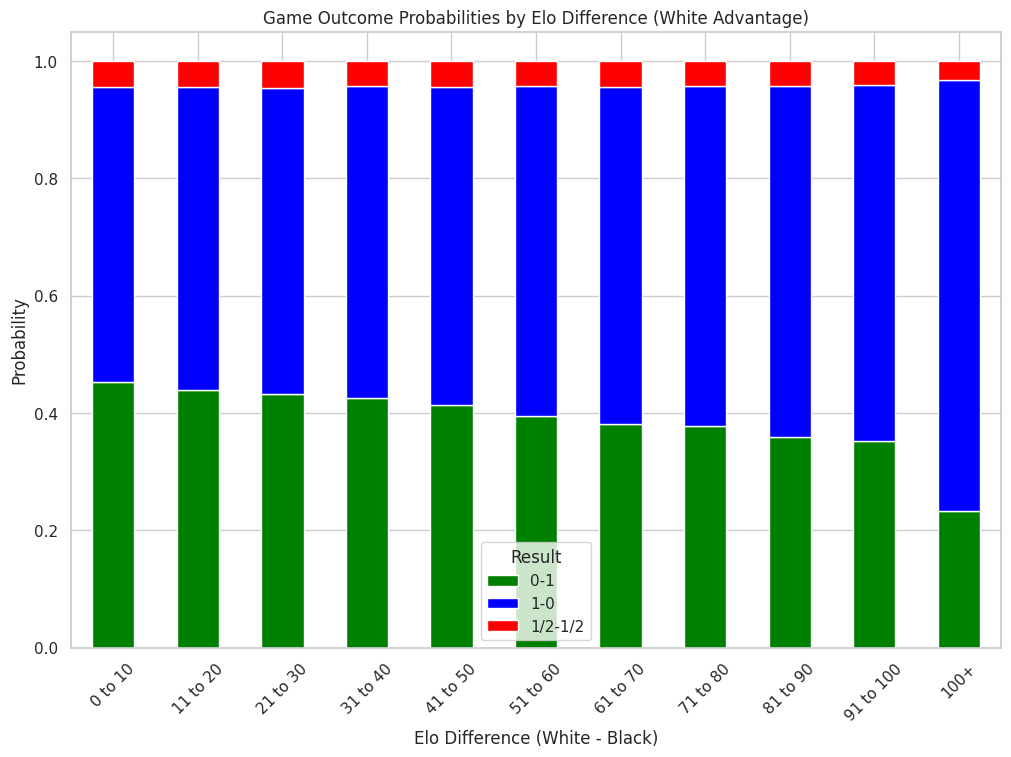


White win Probability for each Elo Group by Elo Difference
 Result                         0-1       1-0   1/2-1/2
WhiteEloGroup EloDiffBin                              
Advanced      0 to 10     0.452041  0.503154  0.044805
              11 to 20    0.431815  0.518944  0.049241
              21 to 30    0.426920  0.527106  0.045974
              31 to 40    0.424532  0.528760  0.046708
              41 to 50    0.412798  0.545636  0.041565
              51 to 60    0.394629  0.562889  0.042482
              61 to 70    0.371854  0.583505  0.044641
              71 to 80    0.375884  0.581509  0.042607
              81 to 90    0.366759  0.593685  0.039556
              91 to 100   0.340222  0.619200  0.040579
              100+        0.230408  0.737616  0.031976
Beginner      0 to 10     0.474820  0.496403  0.028777
              11 to 20    0.460000  0.500000  0.040000
              21 to 30    0.440191  0.507177  0.052632
              31 to 40    0.453039  0.524862  0.022099
    

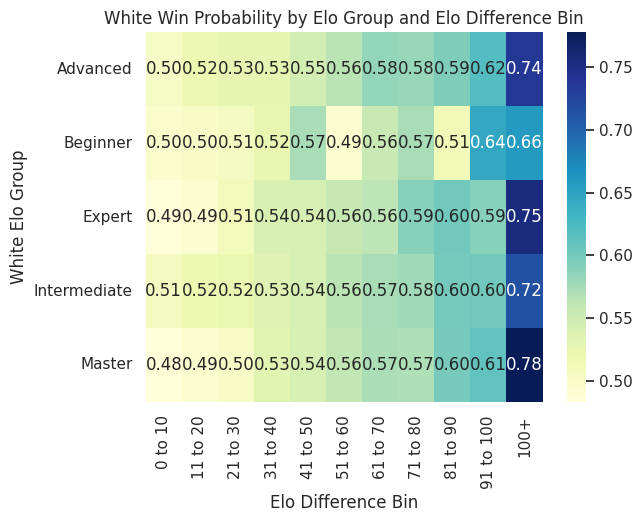


White win ratios for each Elo Group by Elo Difference
 EloDiffBin
0 to 10      0.502836
11 to 20     0.515566
21 to 30     0.522019
31 to 40     0.533045
41 to 50     0.543402
51 to 60     0.562007
61 to 70     0.574238
71 to 80     0.579731
81 to 90     0.597740
91 to 100    0.605948
100+         0.734548
Name: WhiteWinProbability, dtype: float64


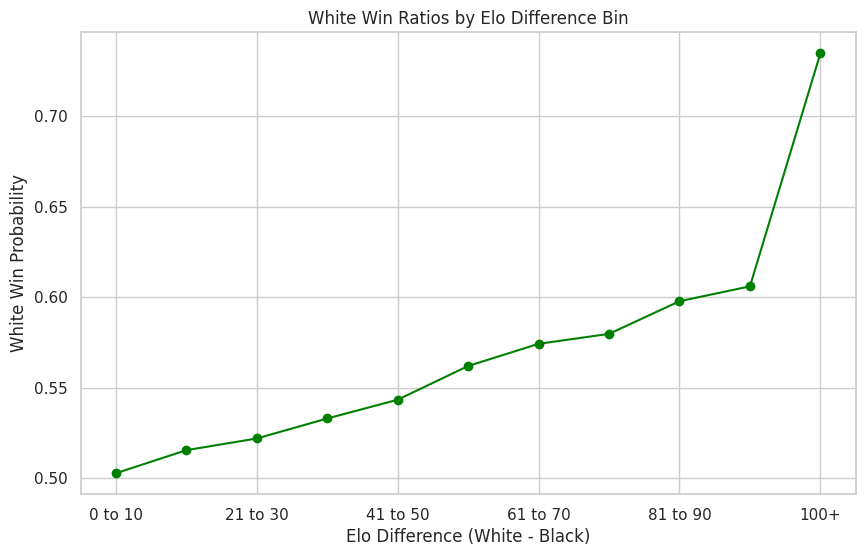

Binary Result Model Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.65      0.65    100563
           1       0.65      0.64      0.65     99374

    accuracy                           0.65    199937
   macro avg       0.65      0.65      0.65    199937
weighted avg       0.65      0.65      0.65    199937
 Binary Result Model Accuracy: 0.6480741433551569


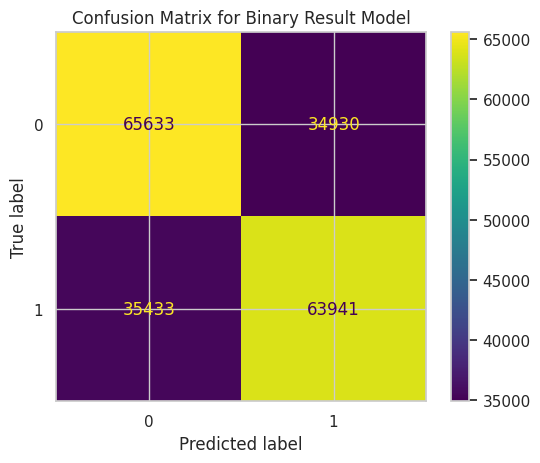

Multi-Class Result Model Classification Report:
               precision    recall  f1-score   support

          -1       0.63      0.61      0.62     92970
           0       1.00      0.00      0.00      7593
           1       0.63      0.70      0.66     99374

    accuracy                           0.63    199937
   macro avg       0.75      0.44      0.43    199937
weighted avg       0.64      0.63      0.62    199937
 Multi-Class Result Model Accuracy: 0.6297033565573156


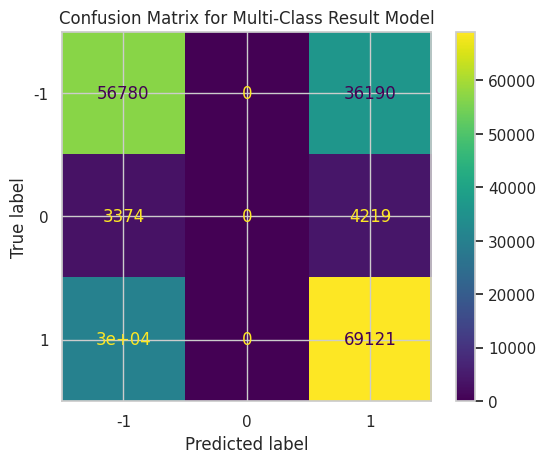

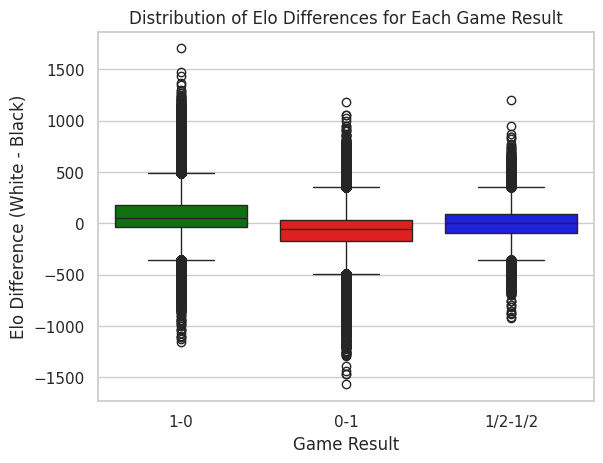

In [7]:
# Calculate the Elo difference between White and Black (keeping sign to indicate advantage)
df_chess['EloDifference'] = df_chess['WhiteElo'] - df_chess['BlackElo']

# ***Differences between White and Black advantage were very subtle and they don't help answer the question
# # Define Elo difference bins and labels for advantages and disadvantages
# elo_diff_bins = [-float('inf'), -100, -90, -80, -70, -60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, float('inf')]
# elo_diff_labels = [
#     '-100+', '-91 to -100', '-81 to -90', '-71 to -80', '-61 to -70', '-51 to -60', '-41 to -50',
#     '-31 to -40', '-21 to -30', '-11 to -20', '-1 to -10', '0 to 10', '11 to 20', '21 to 30', '31 to 40',
#     '40 to 50', '51to 60', '61 to 70', '71 to 80', '81 to 90', '91 to 100', '100+'
# ]

# Define Elo difference bins and labels
elo_diff_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, float('inf')]
elo_diff_labels = ['0 to 10', '11 to 20', '21 to 30', '31 to 40', '41 to 50', '51 to 60', '61 to 70', '71 to 80', '81 to 90', '91 to 100', '100+']

# Create a new column for Elo difference bins
df_chess['EloDiffBin'] = pd.cut(df_chess['EloDifference'], bins=elo_diff_bins, labels=elo_diff_labels)

# Calculate outcome probabilities within each EloDiffBin
outcome_probs_by_diff = (
    df_chess.groupby('EloDiffBin', observed=False)['Result']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
    .drop(columns='*', errors='ignore')
)
print("\nWhite win Probability by Elo Difference\n", outcome_probs_by_diff)

outcome_probs_by_diff.plot(kind='bar', stacked=True, figsize=(12, 8), color=['green', 'blue', 'red'])
plt.title('Game Outcome Probabilities by Elo Difference (White Advantage)')
plt.xlabel('Elo Difference (White - Black)')
plt.ylabel('Probability')
plt.legend(title='Result')
plt.xticks(rotation=45)
plt.show()


# Calculate outcome probabilities for each Elo range and Elo difference bin
outcome_probs_by_elo_and_diff = (
    df_chess.groupby(['WhiteEloGroup', 'EloDiffBin'], observed=False)['Result']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
    .drop(columns='*', errors='ignore')
)
print("\nWhite win Probability for each Elo Group by Elo Difference\n", outcome_probs_by_elo_and_diff)

sns.heatmap(outcome_probs_by_elo_and_diff.loc[:, '1-0'].unstack(), annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('White Win Probability by Elo Group and Elo Difference Bin')
plt.xlabel('Elo Difference Bin')
plt.ylabel('White Elo Group')
plt.show()

# Calculate win ratios by EloDiffBin
df_chess['WhiteWinProbability'] = df_chess['Result'].apply(lambda x: 1 if x == '1-0' else 0)
win_ratios = (
    df_chess.groupby('EloDiffBin', observed=False)['WhiteWinProbability']
    .mean()
)
print("\nWhite win ratios for each Elo Group by Elo Difference\n", win_ratios)

win_ratios.plot(kind='line', marker='o', color='green', figsize=(10, 6))
plt.title('White Win Ratios by Elo Difference Bin')
plt.xlabel('Elo Difference (White - Black)')
plt.ylabel('White Win Probability')
plt.grid(True)
plt.show()

# Convert categorical results to binary values
df_chess['BinaryResult'] = df_chess['Result'].apply(lambda x: 1 if x == '1-0' else 0)

# Select features and labels for model input
X = df_chess[['EloDifference']]
y = df_chess['BinaryResult']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the logistic regression model
binary_result_model = LogisticRegression()
binary_result_model.fit(X_train, y_train)

# Evaluate the model on the test data
binary_result_predictions = binary_result_model.predict(X_test)
binary_result_accuracy = accuracy_score(y_test, binary_result_predictions)
print("Binary Result Model Classification Report:\n", classification_report(y_test, binary_result_predictions), "Binary Result Model Accuracy:", binary_result_accuracy)

# Binary model confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, binary_result_predictions)
plt.title('Confusion Matrix for Binary Result Model')
plt.show()

# Convert categorical results to numeric values (1 = White win, 0 = Draw, -1 = Black win)
df_chess['NumericResult'] = df_chess['Result'].map({'1-0': 1, '1/2-1/2': 0, '0-1': -1})

# Drop rows where 'NumericResult' is NaN
df_chess = df_chess.dropna(subset=['NumericResult'])

# Select features and labels for model input
features = df_chess[['EloDifference', 'WhiteElo', 'BlackElo']]
labels = df_chess['NumericResult']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Train the logistic regression model
multi_result_model = LogisticRegression()
multi_result_model.fit(X_train, y_train)

# Evaluate the model on the test data and get multi-class result model accuracy
multi_result_modelpredictions = multi_result_model.predict(X_test)
multi_result_accuracy = accuracy_score(y_test, multi_result_modelpredictions)
print("Multi-Class Result Model Classification Report:\n", classification_report(y_test, multi_result_modelpredictions, zero_division=True), "Multi-Class Result Model Accuracy:", multi_result_accuracy)

# Multi-class model confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, multi_result_modelpredictions)
plt.title('Confusion Matrix for Multi-Class Result Model')
plt.show()

sns.boxplot(x='Result', y='EloDifference', data=df_chess, palette={'1-0': 'green', '1/2-1/2': 'blue', '0-1': 'red'}, legend=False, hue='Result')
plt.title('Distribution of Elo Differences for Each Game Result')
plt.xlabel('Game Result')
plt.ylabel('Elo Difference (White - Black)')
plt.show()

